# Volatility Scenarios

Custom random-number generators can be used to implement scenarios where shock follow a particular pattern.  For example, suppose you wanted to find out what would happen if there were 5 days of shocks that were larger than average.  In most circumstances, the shocks in a GARCH model have unit variance.  This could be changed so that the first 5 shocks have variance 4, or twice the standard deviation. 

Another scenario would be to over sample a specific period for the shocks.  When using the standard bootstrap method (filtered historical simulation) the shocks are drawn using iid sampling from the history.  While this approach is standard and well-grounded, it might be desirable to sample from a specific period.  This can be implemented using a custom random number generator.  This strategy is precisely how the filtered historical simulation is implemented internally, only where the draws are uniformly sampled from the entire history.

First, some preliminaries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from arch.univariate import GARCH, ConstantMean, Normal

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

This example makes use of returns from the NASDAQ index. The scenario bootstrap will make use of returns in the run-up to and during the Financial Crisis of 2008. 

In [2]:
import arch.data.nasdaq

data = arch.data.nasdaq.load()
nasdaq = data["Adj Close"]
print(nasdaq.head())

Date
1999-01-04    2208.050049
1999-01-05    2251.270020
1999-01-06    2320.860107
1999-01-07    2326.090088
1999-01-08    2344.409912
Name: Adj Close, dtype: float64


Next, the returns are computed and the model is constructed. The model is constructed from the building blocks.  It is a standard model and could have been (almost) equivalently constructed using

```python
mod = arch_model(rets, mean='constant', p=1, o=1, q=1)
```

The one advantage of constructing the model using the components is that the NumPy `RandomState` that is used to simulate from the model can be externally set. This allows the generator seed to be easily set and for the state to reset, if needed.

**NOTE**: It is always a good idea to scale return by 100 before estimating ARCH-type models. This helps the optimizer converse since the scale of the volatility intercept is much closer to the scale of the other parameters in the model. 

In [3]:
rets = 100 * nasdaq.pct_change().dropna()

# Build components to set the state for the distribution
random_state = np.random.RandomState(1)
dist = Normal(seed=random_state)
volatility = GARCH(1, 1, 1)

mod = ConstantMean(rets, volatility=volatility, distribution=dist)

Fitting the model is standard.

In [4]:
res = mod.fit(disp="off")
res

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -8196.75
Distribution:                  Normal   AIC:                           16403.5
Method:            Maximum Likelihood   BIC:                           16436.1
                                        No. Observations:                 5030
Date:                Tue, May 30 2023   Df Residuals:                     5029
Time:                        10:55:35   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0376  1.476e-02      2.549  1.081e-02 [8.

GJR-GARCH models support analytical forecasts, which is the default.  The forecasts are produced for all of 2017 using the estimated model parameters.

All GARCH specification are complete models in the sense that they specify a distribution. This allows simulations to be produced using the assumptions in the model.  The `forecast` function can be made to produce simulations using the assumed distribution by setting `method='simulation'`.  

These forecasts are similar to the analytical forecasts above.  As the number of simulation increases towards $\infty$, the simulation-based forecasts will converge to the analytical values above.

In [5]:
sim_forecasts = res.forecast(start="1-1-2017", method="simulation", horizon=10)
print(sim_forecasts.residual_variance.dropna().head())

                h.01      h.02      h.03      h.04      h.05      h.06   
Date                                                                     
2017-01-03  0.623295  0.637251  0.647817  0.663746  0.673404  0.687952  \
2017-01-04  0.599455  0.617539  0.635838  0.649695  0.659733  0.667267   
2017-01-05  0.567297  0.583415  0.597571  0.613065  0.621790  0.636180   
2017-01-06  0.542506  0.555688  0.570280  0.585426  0.595551  0.608487   
2017-01-09  0.515452  0.528771  0.542658  0.559684  0.580434  0.594855   

                h.07      h.08      h.09      h.10  
Date                                                
2017-01-03  0.697221  0.707707  0.717701  0.729465  
2017-01-04  0.686503  0.699708  0.707203  0.718560  
2017-01-05  0.650287  0.663344  0.679835  0.692300  
2017-01-06  0.619195  0.638180  0.653185  0.661366  
2017-01-09  0.605136  0.621835  0.634091  0.653222  


## Custom Random Generators
`forecast` supports replacing the generator based on the assumed distribution of residuals in the model with any other generator.  A shock generator should usually produce unit variance shocks.  However, in this example the first 5 shocks generated have variance 2, and the remainder are standard normal. This scenario consists of a period of consistently surprising volatility where the volatility has shifted for some reason.

The forecast variances are much larger and grow faster than those from either method previously illustrated. This reflects the increase in volatility in the first 5 days.

In [6]:
forecasts = res.forecast(start="1-1-2017", horizon=10)
print(forecasts.residual_variance.dropna().head())

                h.01      h.02      h.03      h.04      h.05      h.06   
Date                                                                     
2017-01-03  0.623295  0.637504  0.651549  0.665431  0.679154  0.692717  \
2017-01-04  0.599455  0.613940  0.628257  0.642408  0.656397  0.670223   
2017-01-05  0.567297  0.582153  0.596837  0.611352  0.625699  0.639880   
2017-01-06  0.542506  0.557649  0.572616  0.587410  0.602034  0.616488   
2017-01-09  0.515452  0.530906  0.546183  0.561282  0.576208  0.590961   

                h.07      h.08      h.09      h.10  
Date                                                
2017-01-03  0.706124  0.719376  0.732475  0.745423  
2017-01-04  0.683890  0.697399  0.710752  0.723950  
2017-01-05  0.653897  0.667753  0.681448  0.694985  
2017-01-06  0.630776  0.644899  0.658858  0.672656  
2017-01-09  0.605543  0.619957  0.634205  0.648288  


In [7]:
import numpy as np

random_state = np.random.RandomState(1)


def scenario_rng(size):
    shocks = random_state.standard_normal(size)
    shocks[:, :5] *= np.sqrt(2)
    return shocks


scenario_forecasts = res.forecast(
    start="1-1-2017", method="simulation", horizon=10, rng=scenario_rng
)
print(scenario_forecasts.residual_variance.dropna().head())

                h.01      h.02      h.03      h.04      h.05      h.06   
Date                                                                     
2017-01-03  0.623295  0.685911  0.745202  0.821112  0.886289  0.966737  \
2017-01-04  0.599455  0.668181  0.743119  0.811486  0.877539  0.936587   
2017-01-05  0.567297  0.629195  0.691225  0.758891  0.816663  0.893986   
2017-01-06  0.542506  0.596301  0.656603  0.721505  0.778286  0.849680   
2017-01-09  0.515452  0.567086  0.622224  0.689831  0.775048  0.845656   

                h.07      h.08      h.09      h.10  
Date                                                
2017-01-03  0.970796  0.977504  0.982202  0.992547  
2017-01-04  0.955295  0.965540  0.966432  0.974248  
2017-01-05  0.905952  0.915208  0.930777  0.938636  
2017-01-06  0.856175  0.873865  0.886221  0.890002  
2017-01-09  0.851104  0.864591  0.874696  0.894397  


## Bootstrap Scenarios

`forecast` supports Filtered Historical Simulation (FHS) using `method='bootstrap'`.  This is effectively a simulation method where the simulated shocks are generated using iid sampling from the history of the demeaned and standardized return data.  Custom bootstraps are another application of `rng`.  Here an object is used to hold the shocks.  This object exposes a method (`rng`) the acts like a random number generator, except that it only returns values that were provided in the `shocks` parameter.

The internal implementation of the FHS uses a method almost identical to this where `shocks` contain the entire history.

In [8]:
class ScenarioBootstrapRNG(object):
    def __init__(self, shocks, random_state):
        self._shocks = np.asarray(shocks)  # 1d
        self._rs = random_state
        self.n = shocks.shape[0]

    def rng(self, size):
        idx = self._rs.randint(0, self.n, size=size)
        return self._shocks[idx]


random_state = np.random.RandomState(1)
std_shocks = res.resid / res.conditional_volatility
shocks = std_shocks["2008-08-01":"2008-11-10"]
scenario_bootstrap = ScenarioBootstrapRNG(shocks, random_state)
bs_forecasts = res.forecast(
    start="1-1-2017", method="simulation", horizon=10, rng=scenario_bootstrap.rng
)
print(bs_forecasts.residual_variance.dropna().head())

                h.01      h.02      h.03      h.04      h.05      h.06   
Date                                                                     
2017-01-03  0.623295  0.676081  0.734322  0.779325  0.828189  0.898202  \
2017-01-04  0.599455  0.645237  0.697133  0.750169  0.816280  0.888417   
2017-01-05  0.567297  0.610493  0.665995  0.722954  0.777860  0.840369   
2017-01-06  0.542506  0.597387  0.644534  0.691387  0.741206  0.783319   
2017-01-09  0.515452  0.561312  0.611026  0.647824  0.700559  0.757398   

                h.07      h.08      h.09      h.10  
Date                                                
2017-01-03  0.958215  1.043704  1.124684  1.203893  
2017-01-04  0.945120  1.013400  1.084042  1.158148  
2017-01-05  0.889032  0.961424  1.022412  1.097192  
2017-01-06  0.840667  0.895559  0.957266  1.019497  
2017-01-09  0.820788  0.887791  0.938708  1.028614  


## Visualizing the differences
The final forecast values are used to illustrate how these are different.  The analytical and standard simulation are virtually identical.  The simulated scenario grows rapidly for the first 5 periods and then more slowly. The bootstrap scenario grows quickly and consistently due to the magnitude of the shocks in the financial crisis.

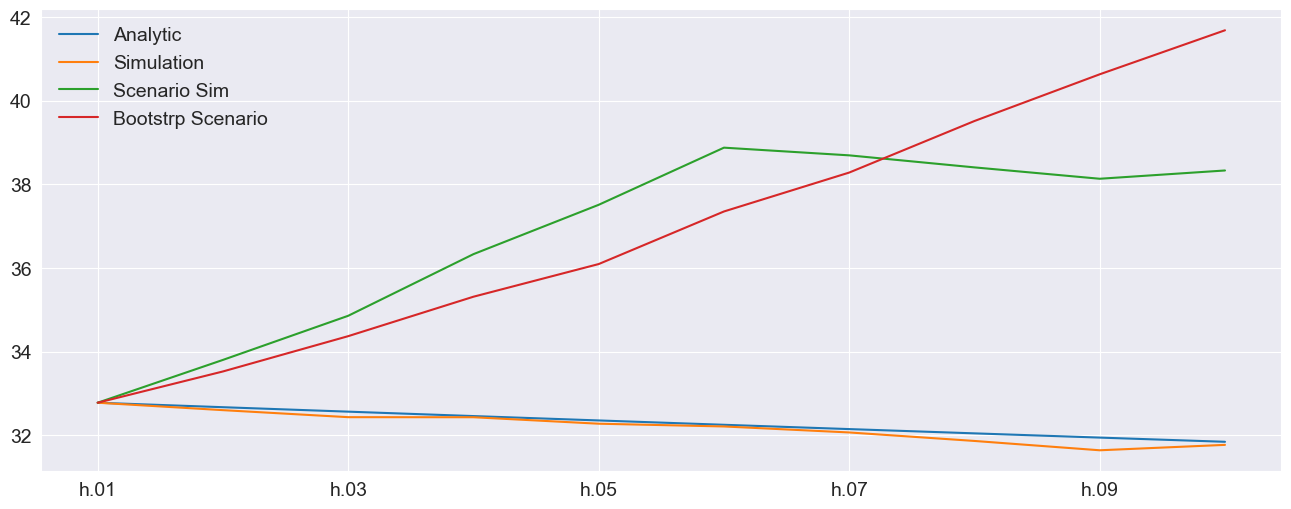

In [9]:
import pandas as pd

df = pd.concat(
    [
        forecasts.residual_variance.iloc[-1],
        sim_forecasts.residual_variance.iloc[-1],
        scenario_forecasts.residual_variance.iloc[-1],
        bs_forecasts.residual_variance.iloc[-1],
    ],
    axis=1,
)
df.columns = ["Analytic", "Simulation", "Scenario Sim", "Bootstrp Scenario"]
# Plot annualized vol
subplot = np.sqrt(252 * df).plot(legend=False)
legend = subplot.legend(frameon=False)

In [10]:
subplot = np.sqrt(252 * df).plot

## Comparing the paths

The paths are available on the attribute `simulations`. Plotting the paths shows important differences between the two scenarios beyond the average differences plotted above. Both start at the same point.

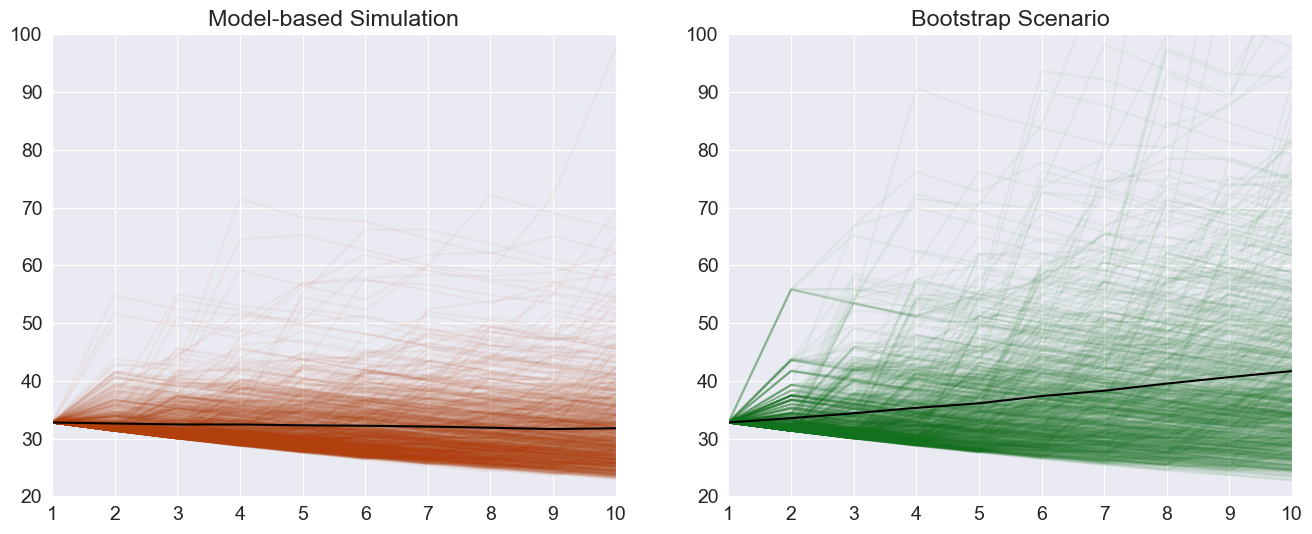

In [11]:
fig, axes = plt.subplots(1, 2)
colors = sns.color_palette("dark")
# The paths for the final observation
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
bs_paths = bs_forecasts.simulations.residual_variances[-1].T

x = np.arange(1, 11)
# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color=colors[1], alpha=0.05)
axes[0].plot(
    x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]), color="k", alpha=1
)
axes[0].set_title("Model-based Simulation")
axes[0].set_xticks(np.arange(1, 11))
axes[0].set_xlim(1, 10)
axes[0].set_ylim(20, 100)

axes[1].plot(x, np.sqrt(252 * bs_paths), color=colors[2], alpha=0.05)
axes[1].plot(
    x, np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]), color="k", alpha=1
)
axes[1].set_xticks(np.arange(1, 11))
axes[1].set_xlim(1, 10)
axes[1].set_ylim(20, 100)
title = axes[1].set_title("Bootstrap Scenario")

## Comparing across the year


A hedgehog plot is useful for showing the differences between the two forecasting methods across the year, instead of a single day. 

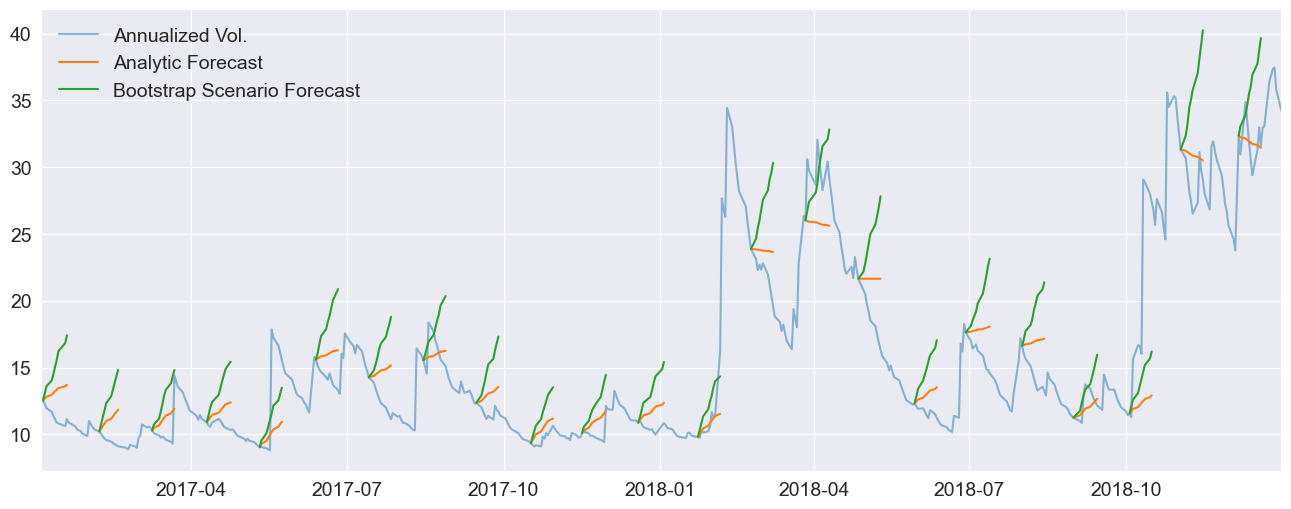

In [12]:
analytic = forecasts.residual_variance.dropna()
bs = bs_forecasts.residual_variance.dropna()
fig, ax = plt.subplots(1, 1)
vol = res.conditional_volatility["2017-1-1":"2019-1-1"]
idx = vol.index
ax.plot(np.sqrt(252) * vol, alpha=0.5)
colors = sns.color_palette()
for i in range(0, len(vol), 22):
    a = analytic.iloc[i]
    b = bs.iloc[i]
    loc = idx.get_loc(a.name)
    new_idx = idx[loc + 1 : loc + 11]
    a.index = new_idx
    b.index = new_idx
    ax.plot(np.sqrt(252 * a), color=colors[1])
    ax.plot(np.sqrt(252 * b), color=colors[2])
labels = ["Annualized Vol.", "Analytic Forecast", "Bootstrap Scenario Forecast"]
legend = ax.legend(labels, frameon=False)
xlim = ax.set_xlim(vol.index[0], vol.index[-1])